# frequency domain source inversion on csic data

## 1.1 preparation for source inversion
#### import libraries
#### load data from estimated Green's functions, represented by the received signals from (relatively) wide-band received signals generating from a Gaussian stf
#### load observed data from experimental signals

In [1]:
#%%capture
#execfile('plot_csic_main')
execfile('plib_load.py')

syn_file='Up_csic_rgauss_chi_f03000000_DT4d_9'
obs_file='Fan07_SRC08_ts2500_mat'


execfile('pinitial_data_load.py')

('the shape of the observed data: ', (3360, 176))
('the shape of the synthetic data: ', (42000, 176))
('synpath: ', 'obf/input/Up_csic_rgauss_chi_f03000000_DT4d_9.su')
('obspath: ', 'obf/input/Fan07_SRC08_ts2500_mat.mat')


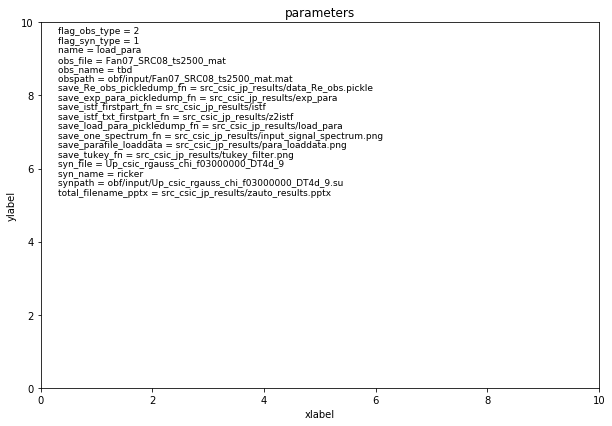

In [2]:
textplot(load_para,save_parafile_loaddata,flag_close=0)

### 1.2 all constants are created here 

UpSampleFactor : 0.0800000000000000017 
sampling rate fsNewsyncomp after resampling : 25000000.000000 Hz
2
189
('freq_step_starNewobs', 26)
('freq_step_endNewobs', 2359)
('freq_step_starNewsyn', 26)
('freq_step_endNewsyn', 2359)
textplot- run


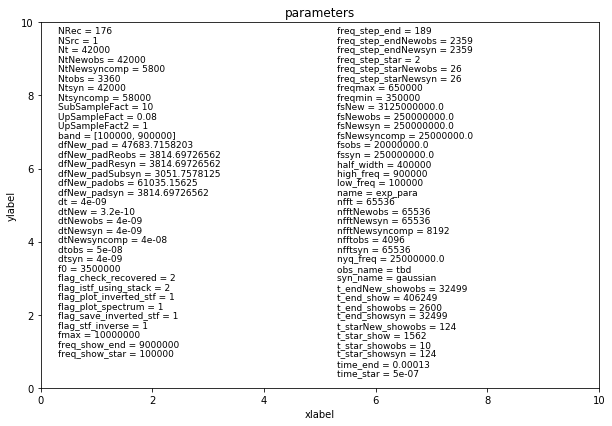

In [3]:
execfile('pconstant_setup.py')

###  1.3 individual trace preprocessing

#### 1.3.1 loading, interpolation, and fft

In [ ]:
trace_seleted = 89
trace_num = trace_seleted
# output: traceNew_obs,traceNew_syn，yf_Newobs，yf_Newsyn
execfile('ptraceprepare.py')

#### 1.3.2 just to plot the fft spectrum


In [ ]:
execfile('pplot_one_spectrum.py')

#### 1.3.3 filer in the frequency domain 

In [ ]:
# filer in the frequency domain 
execfile('ptukey.py')

### 1.5 the actual source inversion program !!!!

In [ ]:
# by controlling the range of the traces, chose stacked or not stacked  
inv_trace_num_star = trace_seleted
inv_trace_num_end = trace_seleted+1 
# inv_trace_num_star = 80
# inv_trace_num_end = 96+1 
execfile('pstf_inverse.py')

### 1.6 filtering the inverted stf signal using a bandpass filter

In [ ]:
%%capture
execfile('pconstant_setup.py')
execfile('pfilter_istf.py')

### 1.7 ploting the inverted stf/sff, with attempts for further improvements using detrend or filtering

In [ ]:
execfile('pconstant_setup.py')
execfile('pstf_inverse_plot.py')

### 1.8 save source inversion as txt - first inversion

In [ ]:
#### output the txt file: t_totalNew_obs and stf_inverted_trace_filtered
### old way, do not use again 
#execfile('pistf_save.py')

In [ ]:
from myFormat.ze_plot_summary import one_signal_plot

one_signal_plot(t_totalNew_obs[0:42000],stf_inverted_trace_filtered[0:42000])

In [ ]:
#np.append(stf_inverted_trace_filtered[star_factor:42000])

# remove delay
star_factor2 = 10000
a = np.zeros(star_factor2)
stf_inverted_trace_filtered_temp = np.append(stf_inverted_trace_filtered[star_factor2:Ntsyn],a, axis=0)
# get rid of values in the begining, to avoid errors in the propagation period
star_factor = 8000
a = np.zeros(star_factor)
#stf_inverted_trace_filtered_shifted = np.append(a, stf_inverted_trace_filtered[:time_step_comp], axis=0)
stf_inverted_trace_filtered_temp = np.append(a,stf_inverted_trace_filtered_temp[star_factor:Ntsyn], axis=0)

# padding zeros after such that specfem can be run with enough steps 
end_factor3 =  Ntsyncomp - Ntsyn
a = np.zeros(end_factor3)

stf_inverted_trace_filtered_temp = np.append(stf_inverted_trace_filtered_temp,a, axis=0)
stf_inverted_trace_filtered_full = bandpass(stf_inverted_trace_filtered_temp, freqmin, freqmax, fsNewobs, zerophase=True)

stf_inverted_trace_filtered_comp = stf_inverted_trace_filtered_full[0:Ntsyncomp:SubSampleFact]
## time array - aftering resampling 
# t_totalNew_obs2 = np.arange(dtNewobs,len(stf_inverted_trace_filtered5)*dtNewobs+dtNewobs,dtNewobs)
# NtsynNew = len(t_totalNew_obs2)

In [ ]:
# new way of saving istf
if flag_save_inverted_stf is 1:
   save_istf_txt_complete_fn = save_istf_txt_firstpart_fn  + '_trstar%03d_trend%03d' % (inv_trace_num_star,inv_trace_num_end)
   if (flag_istf_using_stack is 1): 
       t_total_write = t_totalNew_comp
       stf_write=stf_inverted_stack_trace_filtered
   elif (flag_istf_using_stack is 2): 
       t_total_write = t_totalNew_comp
       stf_write=stf_inverted_trace_filtered_comp
   execfile('pistf_save_func.py')


#### 1.8.1 cross correlation for the travel time difference, before rerun simulation.  - time steps

In [ ]:
print('stf_inverted_trace_filtered shape',stf_inverted_trace_filtered.shape)
print('stf_inverted_trace_filtered5 shape',stf_inverted_trace_filtered5.shape)
print('t_totalNew_obs',t_totalNew_obs.shape)

### travel time 

from seisflows.plugins.misfit import Traveltime
time_step_comp = NtsynNew
time_diff = Traveltime(stf_inverted_trace_filtered[:NtsynNew:stf_subsample_factor],stf_inverted_trace_filtered5[:NtsynNew:stf_subsample_factor],time_step_comp,dtNewobs)
print('difference in time in s for regenerated inverted source:', time_diff)
time_delay = int(round(time_diff/dtNewobs)) 
print('time delay:', time_delay)

#### 1.8.2 delay adjustment

In [ ]:
a = np.zeros(np.abs(time_delay))
#stf_inverted_trace_filtered_shifted = np.append(a, stf_inverted_trace_filtered[:time_step_comp], axis=0)
stf_inverted_trace_filtered_shifted = np.append(stf_inverted_trace_filtered[time_delay:time_step_comp],a, axis=0)

In [ ]:
from myFormat.ze_plot_summary import one_signal_plot
st_temp_star=0
st_temp_end=3000

#one_signal_plot(t_totalNew_obs,stf_inverted_trace_filtered_shifted[:time_step_comp])
one_signal_plot(t_totalNew_obs[st_temp_star:st_temp_end],stf_inverted_trace_filtered_shifted[st_temp_star:st_temp_end])
#one_signal_plot(stf_load[:,0],stf_load[:,1],figtitle='hey',y_label='foo')

#### 1.8.3 save the initial delay adjusted istf 

In [ ]:
#### output the txt file: t_totalNew_obs and stf_inverted_trace_filtered
#
#execfile('pistf_save.py')

save_istf_delay_adjusted_txt_firstpart_fn = str_savefold + '/z2istf_delay_adjusted'
save_istf_txt_complete_fn = save_istf_delay_adjusted_txt_firstpart_fn  + '_trstar%03d_trend%03d' % (inv_trace_num_star,inv_trace_num_end)
stf_write=stf_inverted_trace_filtered_shifted

execfile('pistf_save_func.py')

In [ ]:
#save_istf_delay_adjusted_txt_firstpart_fn

### 1.9 this is to dump the interpolated observed data for later usage 

In [ ]:
##### run once would be enough
execfile('pdata_Re_obs_gene.py')

## 2.0 check the recovered stf's influence, compare the received signals from     
#### specfem2d using inverted stf with the measured signals review the individual trace generated from the inverted source time function 

### 2.1 this is to load back the new observed data

('data from specfem2d using istf:', 'obf/input/Up_sp_mid_20181130_istf_fan7_350k_650k_f0500000_DT4d_8.su')
('the shape of the synthetic data: ', (5800, 176))


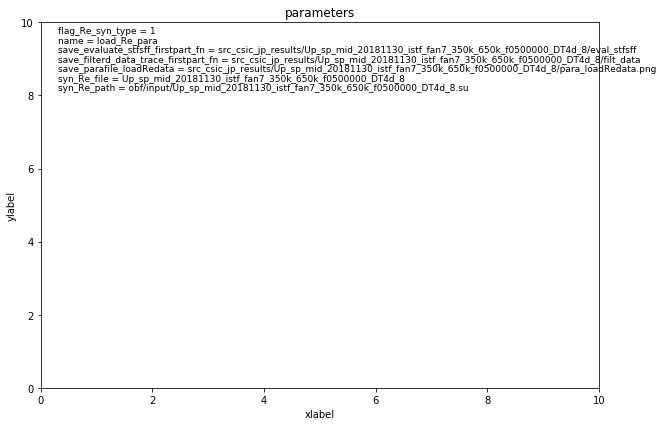

In [4]:
###data recovered as numpy as, one is interpolated observed data; the other is received data generated from the inverted source time function
execfile('plib_load.py')
str_savefold = 'src_csic_jp_results'
load_load_para_pickleopen_fn = str_savefold + '/load_para'
execfile('pdata_Re_obs_load.py')

### 2.2 setup the individual traces to evaluate the inverted source

In [5]:
data_Re_syn.shape

(5800, 176)

UpSampleFactor : 0.0800000000000000017 
sampling rate fsNewsyncomp after resampling : 25000000.000000 Hz
2
189
('freq_step_starNewobs', 26)
('freq_step_endNewobs', 2359)
('freq_step_starNewsyn', 26)
('freq_step_endNewsyn', 2359)
textplot- run
('shape of observed is :', (5800,))
('shape of inverted source signal is :', (5800,))


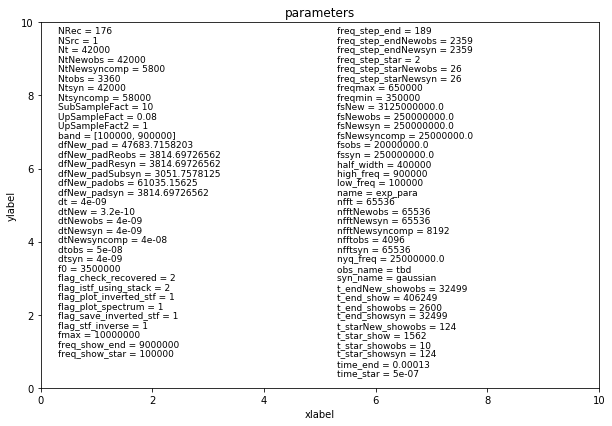

In [6]:
#%%capture
%matplotlib inline
execfile('pconstant_setup.py')

## length for comparison of number of time steps
Ntcomp= NtNewsyncomp; exp_para.Ntcomp = Ntcomp; 
# dtNew = 6e-9;
 
## data recovered as numpy as, one is interpolated observed data; the oth
## er is received data generated from the inverted source time function

## the trace number to compare
#trace_num = trace_seleted
trace_num = 84
trace_interp_obs = data_Re_obs[0:Ntsyncomp:SubSampleFact,trace_num]
print('shape of observed is :', trace_interp_obs.shape)
trace_Re_syn = - data_Re_syn[:NtNewsyncomp,trace_num]
print('shape of inverted source signal is :', trace_Re_syn.shape)

nfftNewobs2 = next_pow_2(Ntcomp);
#yf_Newobs_ = fft(trace_obs, axis=0, n=nfftNewobs)
# fft of the newly recovered signals
yf_trace_interp_obs = fft(trace_interp_obs, axis=0, n=nfftNewobs2)
yf_trace_inverted_syn = fft(trace_Re_syn, axis=0, n=nfftNewobs2)


### 2.3 plot the individual traces to evaluate the inverted source

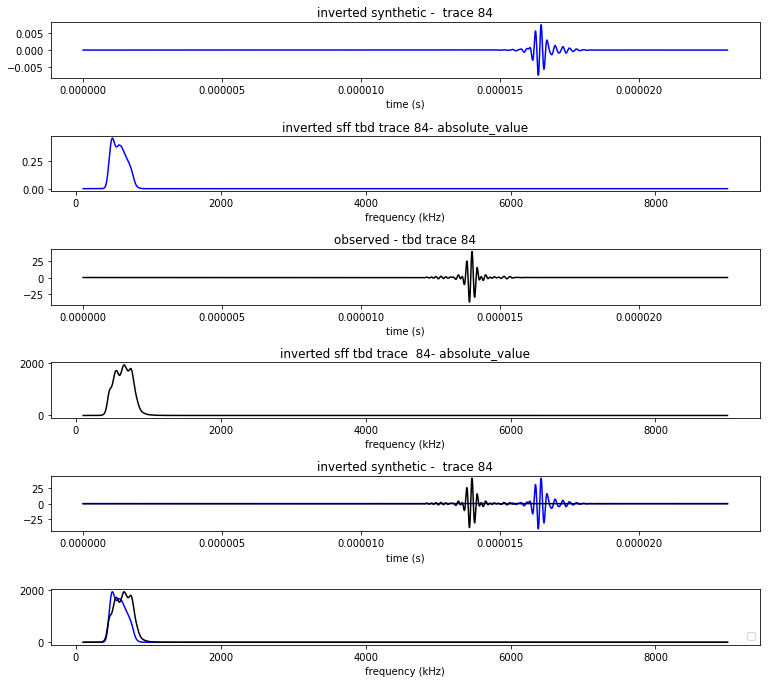

In [7]:
steps_length = Ntcomp
t_star_showsyn = 0
#t_star_showsyn = 10000
t_end_showsyn = steps_length + t_star_showsyn
t_star_showobs = 0
t_end_showobs = steps_length + t_star_showobs
execfile('pplot_Re_one_spectrum.py')


#### 2.3.1 MATLAB - real data delay adjustment

In [8]:
### travel time 

from seisflows.plugins.misfit import Traveltime
time_step_comp = Ntcomp
time_diff = - Traveltime(trace_Re_syn,trace_interp_obs,time_step_comp,dtNewobs)
print('difference in time in s for regenerated inverted source:', time_diff)
time_delay = int(round(time_diff/dtNewobs)) 
print('time delay:', time_delay)

a = np.zeros(np.abs(time_delay))
#stf_inverted_trace_filtered_shifted = np.append(a, stf_inverted_trace_filtered[:time_step_comp], axis=0)
trace_interp_obs_dj = np.append(a,trace_interp_obs[0:time_step_comp-time_delay], axis=0)

('difference in time in s for regenerated inverted source:', 2.4840000000000003e-06)
('time delay:', 621)


In [12]:
 trace_interp_obs_dj.shape

(5800,)

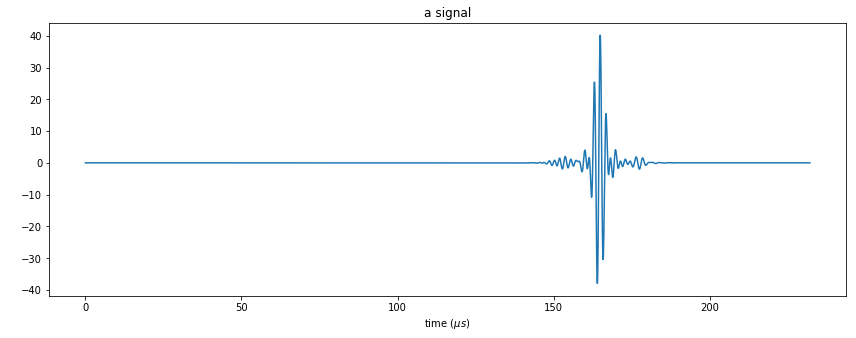

In [13]:
from myFormat.ze_plot_summary import one_signal_plot

one_signal_plot(t_totalNew_comp*1e6,trace_interp_obs_dj)

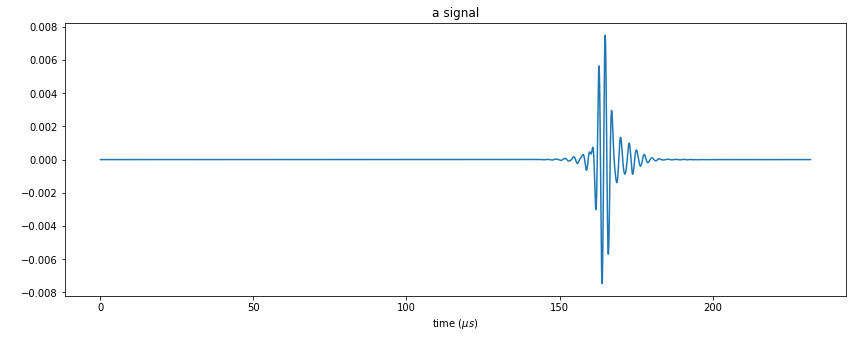

In [14]:
one_signal_plot(t_totalNew_comp*1e6,trace_Re_syn)

In [15]:
print('shape of observed is :', trace_interp_obs.shape)
print('shape of inverted source signal is :', trace_Re_syn.shape)

#yf_Newobs_ = fft(trace_obs, axis=0, n=nfftNewobs)
# fft of the newly recovered signals
yf_trace_interp_obs = fft(trace_interp_obs, axis=0, n=nfftNewsyncomp)
yf_trace_inverted_syn = fft(trace_Re_syn, axis=0, n=nfftNewsyncomp)


('shape of observed is :', (5800,))
('shape of inverted source signal is :', (5800,))


#### 2.3.2 MATLAB - real data delay adjustment

In [16]:
%%capture
inv_trace_num_star=58
inv_trace_num_end=123

a = np.zeros(np.abs(time_delay))

for trace_num in range(inv_trace_num_star,inv_trace_num_end,5):
   
   trace_interp_obs = data_Re_obs[0:Ntsyncomp:SubSampleFact,trace_num]
   trace_interp_obs_dj = np.append(a,trace_interp_obs[0:time_step_comp-time_delay], axis=0)
   trace_interp_obs = trace_interp_obs_dj
   trace_Re_syn = - data_Re_syn[:Ntcomp,trace_num]
   yf_trace_interp_obs = fft(trace_interp_obs, axis=0, n=nfftNewsyncomp)
   yf_trace_inverted_syn = fft(trace_Re_syn, axis=0, n=nfftNewsyncomp)
   execfile('pplot_Re_one_spectrum.py')
   print('plotting the trace recovery = ',trace_num)


In [ ]:
data_Re_obs.shape

### 2.4 multiple figure generation

In [ ]:
%%capture
inv_trace_num_star=58
inv_trace_num_end=118
for trace_num in range(inv_trace_num_star,inv_trace_num_end,5):
   
   execfile('pRetraceprepare.py')
   execfile('pplot_Re_one_spectrum.py')
   print('plotting the trace recovery = ',trace_num)


### 2.5 bandpass everything for inversion 

In [ ]:
freqmin2=500000
freqmax2=1000000
filtered2_trace_Re_syn = bandpass(trace_Re_syn, freqmin2, freqmax2, fsNewobs, zerophase=True)
filtered2_trace_interp_obs = bandpass(trace_interp_obs, freqmin2, freqmax2, fsNewobs, zerophase=True)
yf_filtered2_trace_Re_syn = fft(filtered2_trace_Re_syn, axis=0, n=nfftNewsyn)
yf_filtered2_trace_interp_obs = fft(filtered2_trace_interp_obs, axis=0, n=nfftNewsyn)

t_starNew_showobs = 28000
t_endNew_showobs = 38000

fig, (ax6,ax7,ax8,ax9) = plt.subplots(nrows=4)

ax6.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],filtered2_trace_Re_syn[t_starNew_showobs:t_endNew_showobs],'g-')
ax6.set_title('rec - inverted stf filtered' + str(obs_name) + ' trace' + str(trace_num))
#ax6.set_xlabel('time (us)')
ax6.set_xlabel(r'time ($\mu s$)')

ax7.plot(xf_Newobs[freq_step_starNewobs:freq_step_endNewobs]/1000,np.abs(yf_filtered2_trace_Re_syn[freq_step_starNewobs:freq_step_endNewobs]),'-g')
ax7.set_title('rec - inverted sff filtered' + str(obs_name) + ' trace' + str(trace_num) )
ax7.set_xlabel('frequency (kHz)')

ax8.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],filtered2_trace_interp_obs[t_starNew_showobs:t_endNew_showobs],'m-')
ax8.set_title('rec - inverted stf trace filtered' + str(obs_name) + ' star_trace '+str(inv_trace_num_star)+ 'end_trace '+str(inv_trace_num_end))
ax8.set_xlabel(r'time ($\mu s$)')

ax9.plot(xf_Newobs[freq_step_starNewobs:freq_step_endNewobs]/1000,np.abs(yf_filtered2_trace_interp_obs[freq_step_starNewobs:freq_step_endNewobs]),'-m')
ax9.set_title('rec- inverted sff trace filtered' + str(obs_name) + ' star_trace '+str(inv_trace_num_star)+ 'end_trace '+str(inv_trace_num_end))
ax9.set_xlabel('frequency (kHz)')


plt.tight_layout(rect=[0, 0, 1.2, 2])
fig.show()
save_filterd_data_trace_complete_fn = save_filterd_data_trace_firstpart_fn + 'src01_rec%02d_fmin%d_fmax%d.png' % (trace_num,freqmin2,freqmax2)
#u_receives_signals_fn = 'obf/output/csic/Re_trace_compare_src01_rec%02d.png' % (trace_num)plt.savefig(save_evaluate_stfsff_complete_fn,format='png', dpi=200, bbox_inches='tight')
#plt.close()
plt.savefig(save_filterd_data_trace_complete_fn,format='png', dpi=200, bbox_inches='tight')
add_slide_ze(save_filterd_data_trace_complete_fn,total_filename_pptx)


## 3.0 cross correlation for the travel time difference, after rerun simulation.  - time steps

In [ ]:
print('stf_syn shape',stf_syn.shape)
print('stf_inverted_trace_filtered shape',stf_inverted_trace_filtered.shape)
print('t_totalNew_obs',t_totalNew_obs.shape)

### travel time 

from seisflows.plugins.misfit import Traveltime
time_step_comp = Ntsyn
time_diff = Traveltime(trace_interp_obs[:time_step_comp],trace_Re_syn[:time_step_comp],time_step_comp,dtNewobs)

print('difference in time in s for regenerated inverted source:', time_diff)
time_delay = - int(round(time_diff/dtNewobs))
print('differene in time delay in steps:', time_delay)


In [ ]:
a = np.zeros(np.abs(time_delay))
#stf_inverted_trace_filtered_shifted = np.append(a, stf_inverted_trace_filtered[:time_step_comp], axis=0)
stf_inverted_trace_filtered_shifted2 = np.append(stf_inverted_trace_filtered_shifted[time_delay:time_step_comp],a, axis=0)

In [ ]:
time_step_comp

In [ ]:
from myFormat.ze_plot_summary import one_signal_plot
st_temp_star=0
st_temp_end=3000

#one_signal_plot(t_totalNew_obs,stf_inverted_trace_filtered_shifted[:time_step_comp])
one_signal_plot(t_totalNew_obs[st_temp_star:st_temp_end],stf_inverted_trace_filtered_shifted2[st_temp_star:st_temp_end])
#one_signal_plot(stf_load[:,0],stf_load[:,1],figtitle='hey',y_label='foo')

In [ ]:
%%capture
# supress the printing function 
#trace_num = 120 
#for trace_num in range(0,170,30):

yf_stf_inverted_stack = np.zeros(1, dtype=np.complex)
for trace_num in range(0,176,1):
    #execfile('plot_csic.py')
    execfile('ptraceprepare.py')
    # Now we change into the frequency domain

    yf_NewNormobs = yf_Newobs/(max(yf_Newobs))
    yf_NewNormsyn = yf_Newsyn/(max(yf_Newsyn))

    #yf_obs_maxnormed = yf_obs/max(yf_obs)

    # normalized received signals in the frequency domain, for plotting purposes
    yf_Newsyn_filteredsyn = yf_Newsyn*syn_taper
    yf_Newsyn_filteredNormsyn = yf_Newsyn_filteredsyn/max(yf_Newsyn_filteredsyn)

    yf_Newsyn_filteredobs = yf_Newobs*syn_taper
    yf_Newsyn_filteredNormobs = yf_Newsyn_filteredobs/max(yf_Newsyn_filteredobs)

    
    # Now we invert for the source in the frequency domain (obs as gaussian for Greens'function )
    yf_stf_inverted = np.array([0.0+0.0j])
    for i in range(1, nfftNewsyn):
        if np.abs(yf_Newsyn_filteredsyn[i]) != 0:
            #yf_stf_inverted = np.append(yf_stf_inverted, (yf_Newsyn_filteredNormsyn[i].T*yf_Newobs[i].conj().T)/(yf_Newsyn_filteredNormsyn[i].T*yf_Newsyn_filteredNormsyn[i].conj().T))
            yf_stf_inverted = np.append(yf_stf_inverted, (yf_Newsyn_filteredsyn[i].T*yf_Newobs[i].conj().T)/(yf_Newsyn_filteredsyn[i].T*yf_Newsyn_filteredsyn[i].conj().T))
        else:
            yf_stf_inverted = np.append(yf_stf_inverted, 0.0+0.0j)
    yf_stf_inverted = yf_stf_inverted.conj().T
    #yf_stf_inverted = fft(stf_inverted[0:Nt], axis=0, n=nfft)
    yf_stf_inverted_stack = yf_stf_inverted_stack + yf_stf_inverted
    

In [ ]:
# stf_inverted=ifft(yf_stf_inverted,n=nfftNewsyn)
# stf_inverted_stack=ifft(yf_stf_inverted_stack,n=nfftNewsyn)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(nrows=4)

ax2.plot(xf_Newobs[freq_step_starNewobs:freq_step_endNewobs]/1000,np.abs(yf_stf_inverted[freq_step_starNewobs:freq_step_endNewobs]),'-k')
ax2.set_title('inverted sff ' + str(obs_name) + ' trace  ' + str(trace_num) + '- absolute_value')
ax2.set_xlabel('frequency (kHz)')

ax3.plot(xf_Newobs[freq_step_starNewobs:freq_step_endNewobs]/1000,np.abs(yf_stf_inverted_stack[freq_step_starNewobs:freq_step_endNewobs]),'-k')
ax3.set_title('inverted sff stacked ' + str(obs_name) )
ax3.set_xlabel('frequency (kHz)')

ax4.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],stf_inverted[t_starNew_showobs:t_endNew_showobs],'k-')
ax4.set_title('inverted stf - ' + str(obs_name) + ' trace ' + str(trace_num))
ax4.set_xlabel('time (us)')

ax5.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],stf_inverted_stack[t_starNew_showobs:t_endNew_showobs],'k-')
ax5.set_title('inverted stf - stacked ' + str(obs_name))
ax5.set_xlabel('time (us)')

##ax5.plot(xf_Newobs[freq_step_starNewobs:freq_step_endNewobs]/1000,np.abs(yf_stf_inverted_stack[freq_step_starNewobs:freq_step_endNewobs]),'-k')
#ax5.set_title('inverted stf stacked ' + str(obs_name) + ' trace  ' + str(trace_num) + '- absolute_value')
#ax5.set_xlabel('frequency (kHz)')


plt.tight_layout(rect=[0, 0, 1.5, 2])

In [ ]:
import time


stf = open("obf/output/stf_tbd_csic","w")

for i in range(0,27000):#nstep + delay):
    stf.write("%20.19f " %t_totalNew_obs[i])
    stf.write("%20.19f\n" %stf_inverted_stack[i] )
    # to make sure the i/o is correct with the write function 
    #print(i)
    time.sleep(0.001)

In [ ]:
t_totalNew_obs.shape

In [ ]:
np.abs(yf_Newobs).shape

In [ ]:
import pickle
pickle.dump(exp_para,open('obf/input/exp_para.pickle','wb'))


In [ ]:
trace_inverted_obs = data_obs[:41000,trace_num]
print('shape of observed is :', trace_inverted_obs.shape)

In [ ]:
%%capture
execfile('plot_csic_main')

In [ ]:
trace_inverted_obs.shape

In [ ]:
%%capture
%matplotlib inline
execfile('pconstant_setup.py')

## length for comparison of number of time steps
Ntcomp=Ntsyn; exp_para.Ntcomp = Ntcomp; 
# dtNew = 6e-9;
t_src_comp = np.arange(dtNew,Ntcomp*dtNew+dtNew,dtNew)


## data recovered as numpy as, one is interpolated observed data; the oth
## er is received data generated from the inverted source time function
execfile('pdata_Re_obs_load.py')

## the trace number to compare
trace_num = 88

trace_interp_obs = data_Re_obs[:Ntcomp,trace_num]
print('shape of observed is :', trace_interp_obs.shape)
trace_Re_syn = data_Re_syn[:Ntcomp,trace_num]
print('shape of inverted source signal is :', trace_Re_syn.shape)

#yf_Newobs_ = fft(trace_obs, axis=0, n=nfftNewobs)
# fft of the newly recovered signals
yf_trace_inverted_syn = fft(trace_Re_syn, axis=0, n=nfftNewsyn)


In [ ]:
#print('the shape of the synthetic data using the inverted signals: ', data_Re_syn.shape)
#print('the shape of the observed data: ', data_Re_obs.shape)


In [ ]:
steps_length = 3000

t_star_showsyn = 15000
t_end_showsyn = steps_length + t_star_showsyn

t_star_showobs = 20500
t_end_showobs = steps_length + t_star_showobs

execfile('pplot_Re_one_spectrum.py')


### 1.1 plot the received signals

In [ ]:
1.1 # plot the received signals
time_star= 800 * dtobs
time_end = 2700 * dtobs


t_star_show = int(time_star/dtNew)
t_end_show = int(time_end/dtNew)

t_star_showsyn = int(time_star/dtsyn)
t_end_showsyn = int(time_end/dtsyn)

t_star_showobs = int(time_star/dtobs)
t_end_showobs = int(time_end/dtobs)

t_starNew_showobs = int(time_star/dtNewobs)
t_endNew_showobs = int(time_end/dtNewobs)


fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=7)

ax0.plot(sample_syn[t_star_showsyn:t_end_showsyn],trace_syn[t_star_showsyn:t_end_showsyn],'b-')
ax0.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax0.set_xlabel('time steps')

ax1.plot(sample_obs[t_star_showobs:t_end_showobs],trace_obs[t_star_showobs:t_end_showobs],'k-')
ax1.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax1.set_xlabel('time steps')

ax2.plot(t_total_syn[t_star_showsyn:t_end_showsyn],trace_syn[t_star_showsyn:t_end_showsyn],'b-')
ax2.set_title('synthetic - ' + str(syn_name) + ' trace ' + str(trace_num))
ax2.set_xlabel('time (s)')

ax3.plot(t_total_obs[t_star_showobs:t_end_showobs],trace_obs[t_star_showobs:t_end_showobs],'k-')
ax3.set_title('observed - ' + str(obs_name) + ' trace ' + str(trace_num))
ax3.set_xlabel('time (s)')

ax4.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],traceNew_obs[t_starNew_showobs:t_endNew_showobs],'k-')
ax4.set_title('observed resampled - ' + str(obs_name) + ' trace ' + str(trace_num))
ax4.set_xlabel('time (s)')

ax5.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],traceNew_detrendobs[t_starNew_showobs:t_endNew_showobs],'k-')
ax5.set_title('observed resampled detrend - ' + str(obs_name) + ' trace ' + str(trace_num))
ax5.set_xlabel('time (s)')

ax6.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],traceNew_detrend_filteredobs[t_starNew_showobs:t_endNew_showobs],'k-')
ax6.set_title('observed resampled detrend filtered - ' + str(obs_name) + ' trace ' + str(trace_num))
ax6.set_xlabel('time (s)')


plt.tight_layout(rect=[0, 0, 3, 4])
fig.show()

### 2.0  We now generate the frequency filter that has already been applied to the processed field data. We plot the filter to verify.

In [ ]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
#npts = len(field_trace.data) # resampled trace so different from FieldDataProcessing
#print('npts',npts)
#nfft = _npts2nfft(npts)

tukey_end_freq = 8000000
tukey_length = int(round(tukey_end_freq/dfNew_padResyn))
print('tukey_length',tukey_length)

print('nfft',nfft)
print('nfftNewobs',nfftNewobs)

freq_pos = signal.tukey(tukey_length, alpha=0.02)
print('freq_pos.shape - tukey',freq_pos.shape)
freq_pos = np.pad(freq_pos, 1,'constant',constant_values=0)
print('freq_pos.shape - pad',freq_pos.shape)
freq_pos.resize(nfftNewobs/2)
print('freq_pos.shape - resize',freq_pos.shape)
freq_neg = freq_pos[::-1]
print('freq_neg.shape - freq_pos[::-1]',freq_neg.shape)
syn_taper = np.append(freq_pos, freq_neg)
print('syn_taper.shape - append',syn_taper.shape)
syn_taper
# Plot the filter
freqs = fftfreq(nfftNewsyn, d=dfNew_padResyn)
#freqs = fftfreq(nfft, d=0.000000003)

#plt.plot(freqs[0:120]/1e3,freq_pos[0:120])
plt.plot(xf_Newobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1e3,freq_pos[freq_step_starNewsyn-1:freq_step_endNewsyn-1])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Gain')

In [ ]:
xf_Newobs.shape

In [ ]:
freq_pos[1-1:1600-1]

In [ ]:
dfNew_padResyn

In [ ]:
# Now we change into the frequency domain

yf_NewNormobs = yf_Newobs/(max(yf_Newobs))
yf_NewNormsyn = yf_Newsyn/(max(yf_Newsyn))

#yf_obs_maxnormed = yf_obs/max(yf_obs)

# normalized received signals in the frequency domain, for plotting purposes
yf_Newsyn_filteredsyn = yf_Newsyn*syn_taper
yf_Newsyn_filteredNormsyn = yf_Newsyn_filteredsyn/max(yf_Newsyn_filteredsyn)

yf_Newsyn_filteredobs = yf_Newobs*syn_taper
yf_Newsyn_filteredNormobs = yf_Newsyn_filteredobs/max(yf_Newsyn_filteredobs)


# Plot the spectrums
#plt.plot(freqs,syn_taper)
#plt.plot(freqs,np.abs(yf_syn_maxnormed),color="black")
#plt.plot(freqs,np.abs(yf_stf_obs_maxnormed),color="red")
plt.plot(xf_Newobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1e3,syn_taper[freq_step_starNewsyn-1:freq_step_endNewsyn-1])
plt.plot(xf_Newsyn[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1e3,np.abs(yf_Newsyn_filteredNormsyn[freq_step_starNewsyn-1:freq_step_endNewsyn-1]),color="black")
plt.plot(xf_Newobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1e3,np.abs(yf_Newsyn_filteredNormobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]),color="red")

#plt.plot(xf_Newsyn[freq_step_star-1:freq_step_end-1]/1e3,syn_taper[freq_step_star-1:freq_step_end-1])
#plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,np.abs(yf_obs_maxnormed[freq_step_star-1:freq_step_end-1]),color="black")
#plt.plot(xf[freq_step_star-1:freq_step_end-1]/1e3,np.abs(yf_syn_filtered_maxnormed[freq_step_star-1:freq_step_end-1]),color="red")

plt.legend(['Filter for G', 'Obs Data', "Green's Function - filtered syn signal "])

In [ ]:
# Now we invert for the source in the frequency domain (obs as gaussian for Greens'function )
yf_stf_inverted = np.array([0.0+0.0j])
for i in range(1, nfftNewsyn):
    if np.abs(yf_Newsyn_filteredsyn[i]) != 0:
        #yf_stf_inverted = np.append(yf_stf_inverted, (yf_Newsyn_filteredNormsyn[i].T*yf_Newobs[i].conj().T)/(yf_Newsyn_filteredNormsyn[i].T*yf_Newsyn_filteredNormsyn[i].conj().T))
        yf_stf_inverted = np.append(yf_stf_inverted, (yf_Newsyn_filteredsyn[i].T*yf_Newobs[i].conj().T)/(yf_Newsyn_filteredsyn[i].T*yf_Newsyn_filteredsyn[i].conj().T))
    else:
        yf_stf_inverted = np.append(yf_stf_inverted, 0.0+0.0j)
yf_stf_inverted = yf_stf_inverted.conj().T
#yf_stf_inverted = fft(stf_inverted[0:Nt], axis=0, n=nfft)
stf_inverted=ifft(yf_stf_inverted,n=nfftNewsyn)


### 2.1 post processing the inverted stf

In [ ]:
# filtering 
freqmin=30000
freqmax=5000000

#traceNew_detrendobs = np.copy(signal.detrend(traceNew_obs))
#yf_traceNew_detrendobs = fft(traceNew_detrendobs, axis=0, n=nfftNewobs)
stf_inverted_detrend_filtered = bandpass(stf_inverted_detrend, freqmin, freqmax, fsNewobs, zerophase=True)
yf_stf_inverted_detrend_filtered = fft(stf_inverted_detrend_filtered, axis=0, n=nfftNewobs) 


# stf_inverted_shifted_filtered = bandpass(stf_inverted_shifted, freqmin, freqmax, fs_new, zerophase=True)
# yf_stf_inverted_shifted_filtered = fft(stf_inverted_shifted_filtered, axis=0, n=nfft)


In [ ]:
# sff - source frequency function 
fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4)

ax0.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],stf_inverted[t_starNew_showobs:t_endNew_showobs],'m-')
ax0.set_title('Inverted stf - ' + str(obs_name) + ' trace ' + str(trace_num))
ax0.set_xlabel('time (s)')

ax1.plot(xf_Newobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1000,np.abs(yf_stf_inverted[freq_step_starNewsyn-1:freq_step_endNewsyn-1]),'-m')
ax1.set_title( 'Inverted sff ')
ax1.set_xlabel('frequency (kHz)')

ax2.plot(t_totalNew_obs[t_starNew_showobs:t_endNew_showobs],stf_inverted_detrend_filtered[t_starNew_showobs:t_endNew_showobs],'r-')
ax2.set_title('Inverted detrend filtered stf - ' + str(obs_name) + ' trace ' + str(trace_num))
ax2.set_xlabel('time (s)')

ax3.plot(xf_Newobs[freq_step_starNewsyn-1:freq_step_endNewsyn-1]/1000,np.abs(yf_stf_inverted_detrend_filtered[freq_step_starNewsyn-1:freq_step_endNewsyn-1]),'-r')
ax3.set_title( 'Inverted detrend filtered sff')
ax3.set_xlabel('frequency (kHz)')

#ax1.plot(xf[freq_step_star-1:freq_step_end-1]/1000,np.abs(yf_stf_obs[freq_step_star-1:freq_step_end-1]),'-k')
#ax1.set_title( 'observed - gaussian, stf, absolute_value - zoom in')
#ax1.set_xlabel('frequency (kHz)')

plt.tight_layout(rect=[0, 0, 2, 2])

fig.show()